# Cardiology Meets AI: Classifying Heartbeat Anomalies from Stethoscope Audio

<!--<font style="color:lightgrey;" size="5">Cardiology Meets AI: Classifying Heartbeat Anomalies from Stethoscope Audio</font>!-->

<img style="float: right; width: 350px; padding-top: 10px; padding-right: 5px" src="images/davinci-heart.jpg">

Samuel Moijueh

2019-01-27

<font style="color:#60B0DA;" size="5">Project Description and Dataset</font>

+ [Introduction](#Introduction)
+ [The Heartbeat Sounds Dataset](#Heartbeat-Sounds-Dataset)
+ [Set up Environment](#Set-up-Environment)
+ [Preprocessing: Import and Combine Datasets](#Import-CSV-files)

<font style="color:#60B0DA;" size="5">Exploratory Data Analysis</font>

+ [Exploratory Data Analysis](#Exploratory-Data-Analysis)
+ [Summary Statistics and Visualization](#Summary-Statistics)

<font style="color:#60B0DA;" size="5">Feature Engineering and Data Wrangling</font>

+ [Feature Engineering and Model Selection](#Feature-Engineering,-Model-Selection)
+ [Model Strategy](#Model-Strategy:-Deep-Neural-Networks)
+ [Set up Training/Validation Split](#Set-up-Train-and-Test-Data)
+ [Data Augmentation and Feature Extraction](#Data-Augmentation-and-Feature-Extraction)

<font style="color:#60B0DA;" size="5">Final Model</font>

+ [Deep Neural Network Model](#Keras-Functional-API:-Deep-Neural-Networks)
+ [Make Predictions](#Make-Predictions)

<font style="color:#60B0DA;" size="5">Results and Model Evaluation</font>
+ [Confusion Matrix](#Confusion-Matrix)
+ [Precision, Recall, F-Score](#Precision,-Recall,-F-score)
+ [ROC Curve and AUC](#ROC-Curve-and-AUC)

<font style="color:#60B0DA;" size="5">Conclusion and Closing Remarks</font>
+ [Conclusion and Closing Remarks](#Conclusion)

<!--10. Build Model
11. Evaluate Results
12. Closing Remarks!-->

<img src="images/heartbeat.gif" style="width: 900px">


# Introduction
<a id="Introduction"></a>

Listening to the heart can provide insight into a person’s cardiovascular health and overall well-being. 

In this notebook, we will develop a Deep Neural Network to classify heartbeat sounds into one of four categories. 

This is an end-to-end project. The Jupyter Notebook for the project is available on Github. 

# Heartbeat Sounds Dataset
<a id="Heartbeat-Sounds-Dataset"></a>
Heartbeat Sounds is a machine learning challenge by <a href="http://www.peterjbentley.com/heartchallenge/" target="_blank">Peter Bentley et al</a> to classify heartbeat sounds. The dataset is available to download on the website and <a href="https://www.kaggle.com/kinguistics/heartbeat-sounds/version/1" target="_blank">Kaggle</a>.

The dataset is primarily audio-based: the heartbeat sounds are stored as WAV files that record either normal or abnormal heartbeats. 

The data was gathered from two sources: 
+ Dataset A is from the general public via the iStethoscope Pro iPhone app. 
+ Dataset B is from a clinical trial in hospitals using the digital stethoscope DigiScope. 

Dataset A contains 124 labelled sound clips from four classes: _normal_, _murmur_, _extra heart sound_, and _arfifact_. Dataset B contains 461 labelled sound clips from three classes: _normal_, _murmur_, _extrasystole_. 


### Audio Files Included
In total, 585 audio files of field recordings (see description above). The sound clips vary in length between 1 and 30 seconds. Sound have been clipped to reduce excessive noise and provide the most salient fragment of the sound.

### Meta-Data Files Included

+ CSV files containing audio segmentation data, giving time locations of the S1 (lub) and S2 (dub) sounds within the Normal audio files for both datasets.

+ CSV files with the label annotation for both datasets.

<img src="images/conditions_final2.jpg" style="width: 750px">

# Set up Environment
<a id="Set-up-Environment"></a>
Import packages and modules, define constant variables

In [1]:
""" Basic Utils """
import warnings
from IPython.display import HTML, IFrame

""" Data Analysis and Visualization """
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import label_binarize
import EDA; import MFCC
from scipy import interp

""" Audio Analysis """
import librosa.display
import scipy.io.wavfile
from scipy.fftpack import dct

""" Model Evaluation """
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import scikitplot as skplt

""" Keras Functional API """
from keras.layers import Input, Dense, Dropout, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


INPUT_PATH = "input/"
AUDIO_DURATION = 2
SAMPLE_RATE = 22050

Using TensorFlow backend.


# Import CSV files
<a id="Import-CSV-files"></a>

+ import and store the CSV file data into a pandas dataframe

In [2]:
df_a = pd.read_csv(INPUT_PATH + 'set_a.csv').drop('sublabel', axis = 1).dropna()
df_b = pd.read_csv(INPUT_PATH + 'set_b.csv').drop('sublabel', axis = 1).dropna()

#  Combine Datasets
<a id="Combine-Datasets"></a>
We can combine the audio clips from `Dataset A` and `Dataset B` despite them being from different sources. 

Since the audio clips are in the same file format (WAV file) and contain the same type of data (heatbeat sounds), they should have common attributes on which we can train. 

The combined dataset will have five classes: _normal_, _murmur_, _extra heart sound_, _extrasystole_, and _arfifact_.  

#### Count of Combined Dataset

| source | condition  |  #  |
|--------|------------|-----|
| a      | artifact   | 40  |
| .      | murmur     | 34  |
| .      | normal     | 31  |
| .      | extrahls   | 19  |
| b      | normal     | 320 |
| .      | murmur     | 95  |
| .      | extrastole | 46  |

## Combining normal and extrastole categories

We can also combine the normal and extrastole categories. 

We will use Pandas to combine the data.


In [3]:
df = pd.concat([df_a, df_b], ignore_index=True)

## Load and Preprocess the Data

+ load and store the audio series data into the dataframe
+ normalize the length of the audio clips to 2 seconds
+ downsample the audio to 22050 data points per second
+ convert the audio time series to numpy arrays

In [4]:
def load_audio(fname, offset=0, duration=None):
    """loads the audio"""
    try:
        y, sr = librosa.load(INPUT_PATH + "set_a/" + fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
    except IOError:
        y, sr = librosa.load(INPUT_PATH + "set_b/" + fname, sr=SAMPLE_RATE, offset=offset, duration=duration)
    except NameError:
        print("{0} does not exist".format(fname))
    return(y)

def combine_normal_extrastole(f):
    if f == "normal":
        return("normal/extrastole")
    elif f == "extrastole":
        return("normal/extrastole")
    else:
        return(f)

In [5]:
df['fname'] = df['fname'].apply(lambda f:f.split('/')[1])
df['time_series'] = df['fname'].apply(load_audio)   # audio signals
df['duration (seconds)'] = round(df['time_series'].apply(len) / SAMPLE_RATE, 1)
df['label'] = df['label'].apply(combine_normal_extrastole)

In [6]:
display(HTML('<h1 style="text-indent: 300px;">Subset of Audio Time Series Data </h1>'))
pd.concat([df.head() , df.tail()], ignore_index=True)

,dataset,fname,label,time_series,duration (seconds)
0,a,artifact__201012172012.wav,artifact,"[2.2960085e-05, -0.00012982322, -0.00018070513...",9.0
1,a,artifact__201105040918.wav,artifact,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",9.0
2,a,artifact__201105041959.wav,artifact,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",9.0
3,a,artifact__201105051017.wav,artifact,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",9.0
4,a,artifact__201105060108.wav,artifact,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",9.0
5,b,normal__206_1308159601959_C.wav,normal/extrastole,"[0.002638847, 0.0029593366, 0.003284204, 0.003...",3.5
6,b,normal__214_1308245489717_A.wav,normal/extrastole,"[0.007579559, 0.007860259, 0.0076191076, 0.006...",1.5
7,b,normal__175_1307987962616_B.wav,normal/extrastole,"[0.0013529711, 0.0024457676, 0.003745941, 0.00...",2.2
8,b,extrastole__151_1306779785624_B.wav,normal/extrastole,"[-0.005136064, -0.0041970294, -0.0025254476, -...",11.3
9,b,murmur_noisymurmur_165_1307109069581_C1.wav,murmur,"[-0.014550511, -0.016285023, -0.017363165, -0....",3.6


# Exploratory Data Analysis
<a id="Exploratory-Data-Analysis"></a>

We can <font color='orange'> 1) </font> generate summary statistics, <font color='orange'> 2) </font> plot visualizations, and <font color='orange'> 3) </font> even listen to a subset of the audio to get a sense of the data and identify potential challenges, and answer key questions. 

<!--These aspects of EDA will give us insight into the following:!-->

#### Summary Statistics  and Visualization
+ How does the audio duration vary among classes? 
+ What is the class distribution in the dataset? Is there an inbalance?

#### Inspecting the Audio and Data Quality
+ What is the overall audio quality?
+ Does one dataset have better audio quality than the other?

#### Feature Engineering
+ What features can we use to train the model?
+ What length of audio is needed to build a robust classifier (half a second, 4 seconds, 10 seconds)? 
+ Will there be enough information in the length of audio we decide to sample?

<br>
We begin with Summary Statistics and Visualization

In [7]:
cond_counts = df['label'].value_counts()
min_duration = df.groupby('label')['duration (seconds)'].min()
max_duration = df.groupby('label')['duration (seconds)'].max()
mean_duration = df.groupby('label')['duration (seconds)'].max()
total_duration = df.groupby('label')['duration (seconds)'].sum()

audio_duration_dict = {'min duration (sec)' : min_duration, 'max duration (sec)': max_duration, 'mean duration (sec)':mean_duration, 
                       'total duration (sec)':total_duration, 'number of samples (#)': cond_counts}
audio_duration_summary = pd.DataFrame(audio_duration_dict)
display(HTML('<h1 style="text-indent: 300px;">Auditory Duration Summary</h1>'))
pd.DataFrame(audio_duration_dict)

,min duration (sec),max duration (sec),mean duration (sec),total duration (sec),number of samples (#)
artifact,9.0,9.0,9.0,360.0,40
extrahls,0.9,9.0,9.0,130.5,19
murmur,0.9,24.2,24.2,1001.7,129
normal/extrastole,0.8,27.9,27.9,2486.5,397


# Summary Statistics
<a id="Summary-Statistics"></a>

The table above indicates that there is class imbalance in both the number of samples per label and the mean duration per label. This class inbalance will be problematic later when we train the model (as we will discuss later).

# Visualization

The audio distribution of the dataset again illustrates that there a degree of class inbalance.

The code used to generate the Plots below are available on the Github Repository.

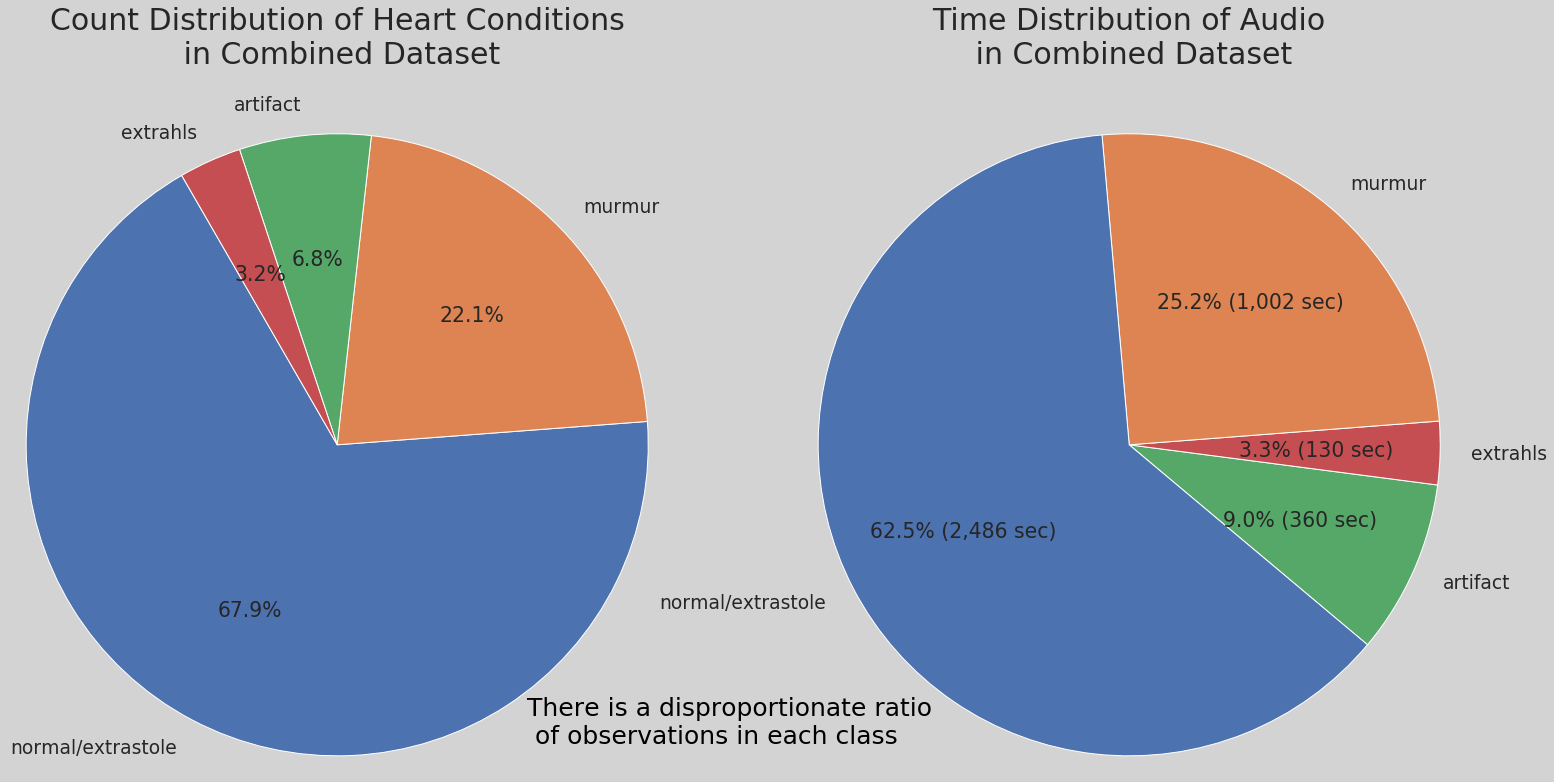

In [8]:
class_labels = list(cond_counts.index)
time_labels = list(total_duration.index)
label_counts = cond_counts.tolist()
duration_count = total_duration.tolist()

EDA.plot_two_distr(class_labels, label_counts, time_labels, duration_count)

We can also look at the source distribution of the data.

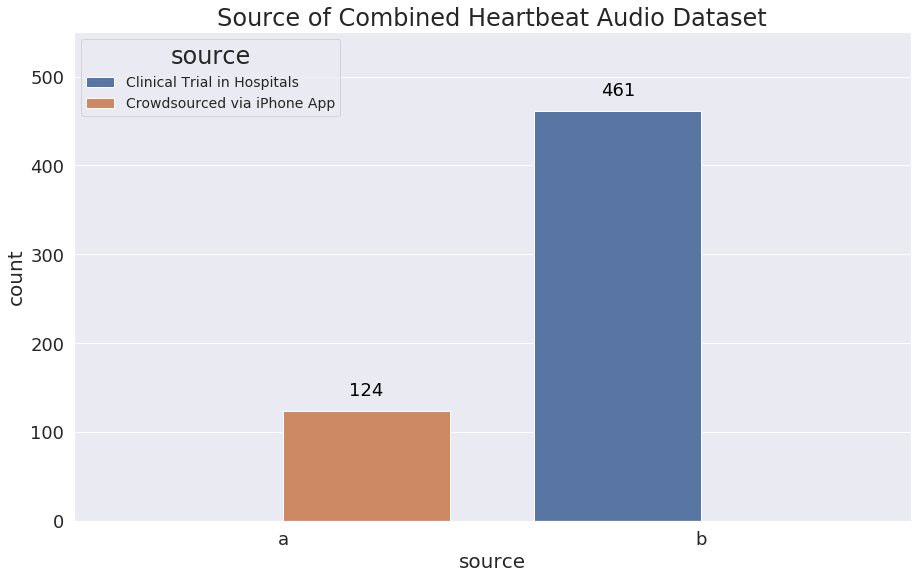

In [9]:
source_count = df['dataset'].value_counts()
l = source_count.to_frame()
l.reset_index(inplace=True)
l.columns = ['source', 'count']

EDA.plot_source_distr(l)

The majority of the audio files are from `Dataset B`.

`Dataset B` may have better audio quality than Dataset A since the data was collected in a controlled environment (clinical setting vs crowd sourcing via an iPhone app).

We can mitigate this possible audio quality disparity by checking that the training and validation sets have proportionate amounts of `Dataset A` and `Dataset B` audio for each labelled class. By doing this, we ensure that there is a proportionate number of "hard" and "easy" cases to learn and predict.

### Oscillogram and Spectrogram

We can visualize the audio signals of the recordings.
+ A **oscillogram** is a measure of a sound wave's amplitude vs time.

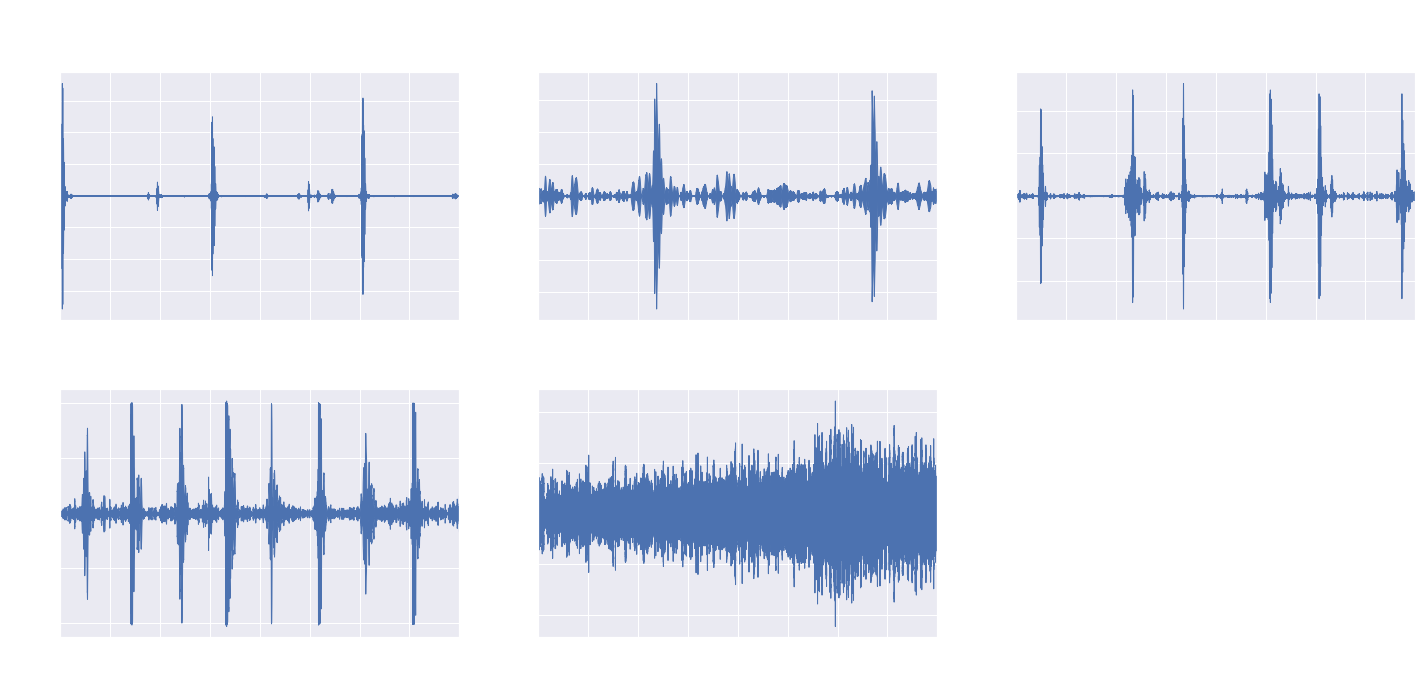

In [10]:
def get_time_series(audio_fname,df):
    """" Helper function: returns the audio signal time series data """
    y = df.loc[df['fname'] == audio_fname]['time_series'].values[0]
    return(y)

samples = ['normal__201103170121.wav', 'murmur__201101180902.wav', 'extrahls__201101241423.wav',
            'extrastole__235_1308749032454_B.wav', 'artifact__201106171003.wav']

EDA.plot_signals(samples)

### We can begin to derive trainable features for classification

<img src="images/design5f.jpg" style="width: 900px">

<!--From this analysis we've derived two features
The plots above give an indication of what features might be useful for classifying the different conditions.
+ The difference between the upper and lower amplitude of the signal. 
+ The rate and frequency of the oscillations along the audio time series.!-->


## Audio Analysis

<font color='orange'> 1) </font> Amplitude is not a good feature for distuguishing heartsounds.
   + Amplitude is unrelated to the type of heart sound, despite what the plots above would suggest. 
   + Rather, amplitude is proportional to the **volume** of the audio.
   + A wave with a large amplitude will be perceived as louder than a wave with a small amplitude.
   + Audio can be recorded at any volume.

<br>
<font color='orange'> 2) </font> Frequency **is** a good feature for the model. We can drop Tempo and Period from the model.
   + Frequency, Period, and Tempo are dependant on one another.
   + For example, if you doubled the frequency of a wave, you would need to half the period, or double the speed.
   + Frequency is easily measured and most commonly used in digital signal processing (DSP) as we will discuss.


## Feature Transformation: Mel Frequency Cepstral Coefficients (MFCCs)

In digital signal processing, a commonly used transformation is the MFCCs (<a href="https://en.wikipedia.org/wiki/Mel-frequency_cepstrum" target="_blank">Mel-frequency cepstral coefficients</a>). Here is a <a href="http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/" target="_blank">blog post</a> explains the MFCCs and how they are derived from the audio signal. MFCCs are commonly used as features in speech recognition. 

<br>
We usually only consider the first 13 MFCCs in feature extraction. Here is a <a href="https://www.quora.com/In-speech-processing-why-do-we-consider-only-first-13-MFCCs" target="_blank">resource</a> that explains why.

<br>
MFCCs are a representation of the audio frequency. Below is a visualization of the Ceptral Coefficients vs Time.

The **spectrogram** shows how the cepstral coefficients hanges over time. The code used to produce this visualization is available on the Github respository.

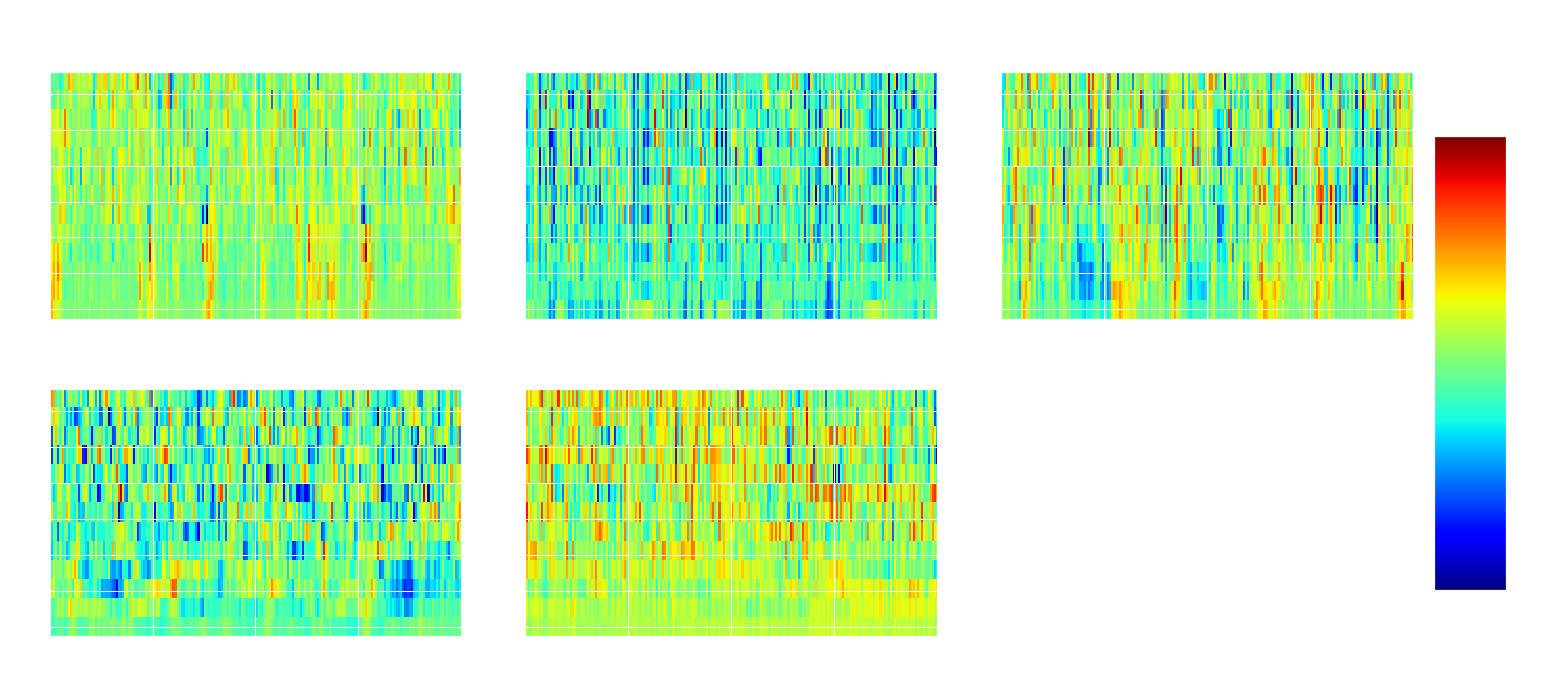

In [11]:
MFCC.plot_mfccs(samples)

# Audio Recordings
Finally, we can listen to audio of each type of heart condition. Doing so will help us understand how the categories differ from one another.

In [12]:
s = open('audio_clips.txt', 'r').read()

display(HTML("""<img style="position:absolute; top: 370px; left: 730px; width:500px; height:auto;" src="images/volume.jpg">"""))
HTML(s)

Normal Heartbeat,Murmur Heartbeat


# Feature Engineering, Model Selection
<a id="Feature-Engineering,-Model-Selection"></a>

We now have a better idea of what features are useful for audio classication:

<font color='orange'> 1) </font> Mel-frequency cepstral coefficients (MFCCs)

+ these are coefficients that collectively make up the short-term power spectrum of a sound

<font color='orange'> 2) </font> Spectral Bandwidth
+ the difference between the upper and lower frequencies in a continuous band of frequencies
<img style="float: right; padding-top: 20px; padding-left: 20px; padding-bottom: 20px; width: 800px" src="images/spectral_bandwidth3.png">

<font color='orange'> 3) </font> Zero Crossing Rate
+ the rate of sign changes along an audio time series. This is a key feature for classifying percussive sounds. Heartbeats are percussive. This will be a good feature for the audio classifier.
    
#### We will use the _Librosa_ library to extract these features.

<br>

## Model Selection

Once we have our features, we can select a model. 

There a couple of neural network architectures commonly used in speech and audio recognition.

#### Convolutional Neural Networks
One industry approach is to use Convolutional Neural Networks (CNN). 

In the EDA, we generated a spectrogram visualization of the mel frequency cepstral coefficients (MFCCs).

To implement a CNN, we would add a channel dimension (analogous to RGB for image recognition) to the MFCCs array. This array would then be fed to the convolution layers for additional feature extraction. This approach is interesting because it transforms the audio classification problem into technically an image classification problem. CNNs are good at <font color='orange'> 1) </font> detecting local feature patterns (edges, textures, etc) in different parts of the image and <font color='orange'> 2) </font> capturing hierarchical features which become subsequently complex with every layer.

#### Recurrent Neural Networks
Another industry approach is to use Recurrent Neural Networks/LSTM. These are quite interesting as well. Recurrent Neural Networks are great for modeling features that change over time. Because the MFCCs have an implicit time component, recurrent neural network would also be a viable option.


#### Deep Neural Networks

We will be implementing a deep neural network. Because of the _subtle_ distinction of audio in the dataset, we will need additional features for **robust** classification. A tentative architecture of the DNN is outlined below. The neural network will output probability estimates for each class.

 <p style="color:#60B0DA;font-size:26px;text-indent:420px">Tentative Architecture of DNN</p>

<img style="float: center; padding-top: 20px; padding-left: 20px; padding-bottom: 20px; width: 900px" src='images/NN2.jpg'>

In [13]:
""" Functions for Feature Extraction """

def new_extract_mfccs(y):
    return(np.mean(librosa.feature.mfcc(y, sr=SAMPLE_RATE, n_mfcc=13).T,axis=0))

def new_extract_zcr(y):
    return(np.mean(librosa.feature.zero_crossing_rate(y)))

def new_extract_bandwidth(y):
    return(np.mean(librosa.feature.spectral_bandwidth(y, SAMPLE_RATE)))

# Model Strategy: Deep Neural Networks
<a id="Model-Strategy:-Deep-Neural-Networks"></a>
<br>
#### Challenges in using a deep learning approach
<br>

<font color='orange'> 1) </font> To achieve high performance, deep networks require extremely large amounts of data. The more labelled data we have, the better our model performs. Currently, there are only 585 labelled audio clips. To generate more labelled data, we will have to get creative.

<br>
#### The nature of the data requires a bit of strategy as well.

<br>
<font color='orange'> 2) </font> There is a degree of class imbalance. We will discuss the complications of this in depth in a later section. 

<font color='orange'> 3) </font>  Audio is unstructured data. From the EDA, we derived trainable features from the model.

<font color='orange'> 4) </font> Audio is a different from most data because it is being sampled so frequently. For example, audio recorded at a sample rate of 44100 will have 44100 data point per second.

<font color='orange'> 5) </font> The audio clip in the dataset vary in length between 1 and 30 seconds. We have to decide what length of audio is needed to build a robust classifier, and then we have to normalize all of the audio in the training data to that length.

## == Solution == 

<br>
From the EDA, we saw that two seconds of audio is a decent length of time to extract for trainable features. Several heartbeats occurred in this short time interval.

<br>

We will only use 2 seconds of audio for each sample. Again, this is relative small. The benefit of this is that in real time, the model would be able to quickly discern different heartsound classifications. 

<br>
Because data is scarce in the deep learning approach, we want to utilize as much data as we can. To generate more samples, we will split the audio into 2 second chunks along the length of the audio. We will **only** do this with the training data. 

<br>

After splitting the audio and relabelling the audio, we will re-evaluate the time distribution of audio. We will oversample the minority classes to even out the time distribution of the dataset.

### We can proceed with the model now that we've outlined a strategy

# Set up Train and Test Data
<a id="Set-up-Train-and-Test-Data"></a>

We will split the combined audio data in a 70/30 training/testing split using Pandas.

In [14]:
training_df = df.sample(frac = 0.7, random_state=42)
testing_df = df[~df['fname'].isin(training_df['fname'])]

### Sanity Check: Training/Testing Split

The training and testing datasets rows should add up to 585.

In [15]:
print("=== Training Dataset ===")
print(training_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}\n".format(len(training_df)))
print("=== Test Dataset ===")
print(testing_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}".format(len(testing_df)))

=== Training Dataset ===
dataset  label            
a        artifact              27
         murmur                25
         normal/extrastole     22
         extrahls              11
b        normal/extrastole    258
         murmur                67
Name: label, dtype: int64

number of rows = 410

=== Test Dataset ===
dataset  label            
a        artifact              13
         murmur                 9
         normal/extrastole      9
         extrahls               8
b        normal/extrastole    108
         murmur                28
Name: label, dtype: int64

number of rows = 175


#### The results above show that the Data was split properly
+ There is no <a href="https://machinelearningmastery.com/data-leakage-machine-learning/" target="_blank">data leakage</a>. The rows add up to 585. 
+ The training and validation sets have rougly proportionate amounts of Dataset A and Dataset B audio for each labelled class. 
    + There is a proportionate number of "hard" and "easy" cases to learn and predict.

# Data Augmentation and Feature Extraction
<a id="Data-Augmentation-and-Feature-Extraction"></a>

We will generate more training data by splitting two seconds of audio along the length of existing audio files. This will effectively increase the sample size of the training data.

In [16]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

"""Splits the audio into 2 second chunks"""
def split_audio(fname):
    new_training_df = pd.DataFrame()
    duration =  training_df[training_df['fname'] == fname]['duration (seconds)'].values[0]
    i = 0; count = 1
    my_list = []
    
    y = load_audio(fname,0,2)            
    if duration < 2:
        y = repeat_to_length(y, SAMPLE_RATE*2)
        
    while True:
        if i > 0:            
            y = load_audio(fname, offset=i, duration=AUDIO_DURATION)
        
        data = {
         'fname' : fname + "_" + str(count),
         'label' : df[df['fname'] == fname]['label'].values[0],
         'time_series' : [y],
         'mfccs' : [ new_extract_mfccs(y) ],
         'zcr' : [ new_extract_zcr(y) ],
         'bandwidth' : [ new_extract_bandwidth(y) ],
         'duration (seconds)' : round(len(y) / SAMPLE_RATE, 1)
        }
        
        my_list.append(pd.DataFrame(data))
        
        i += 2; count += 1
        if (i + 2) > duration: break
    my_list = pd.concat(my_list)
    new_training_df = new_training_df.append(pd.DataFrame(my_list))
    
    return(new_training_df)

In [17]:
""" Generate More Training Data """
new_training_df = training_df['fname'].apply(split_audio)

keys = [s for s in new_training_df]
new_training_df = pd.concat(keys)

### Sanity Check: Splitting the Audio

The duration of all the training data audio should be 2 seconds each.

In [18]:
""" List the unique values in the duration column """
new_training_df['duration (seconds)'].unique()

array([2.])

#### The results above show the Training Data was properly split
+ The audio in the training data are 2 seconds each

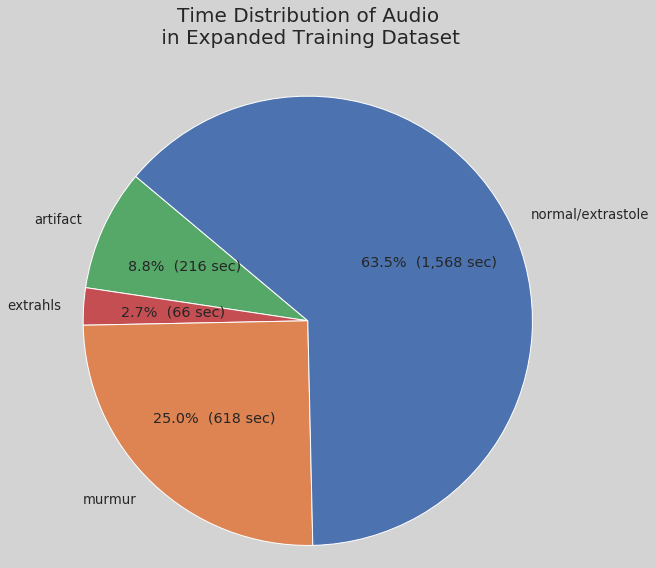

In [19]:
total_duration = new_training_df.groupby('label')['duration (seconds)'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

## Inspect Dataframe

In [20]:
display(HTML('<h1 style="text-indent: 300px;">Subset of Training Dataset with Features</h1>'))
pd.concat([new_training_df.head(), new_training_df.tail()], ignore_index=True)

,fname,label,time_series,mfccs,zcr,bandwidth,duration (seconds)
0,normal__154_1306935608852_B1.wav_1,normal/extrastole,"[-0.015450756, -0.01580485, -0.015002046, -0.0...","[-391.29067089648333, 167.3303461641817, 64.35...",0.007240,330.102199,2.0
1,normal__127_1306764300147_B.wav_1,normal/extrastole,"[0.01090053, 0.012004282, 0.012388631, 0.01202...","[-389.3938164931766, 167.86429914909274, 60.70...",0.008896,342.592143,2.0
2,normal__127_1306764300147_B.wav_2,normal/extrastole,"[0.06184606, 0.070179194, 0.07609761, 0.079762...","[-382.3541760208843, 167.0945078860575, 60.527...",0.009855,370.483015,2.0
3,normal__127_1306764300147_B.wav_3,normal/extrastole,"[0.023409838, 0.024798013, 0.024810065, 0.0236...","[-395.0892441842912, 174.6923233155667, 60.373...",0.010198,371.098706,2.0
4,normal__127_1306764300147_B.wav_4,normal/extrastole,"[-0.10985133, -0.098912016, -0.07209675, -0.02...","[-373.23692169381155, 146.83968457412163, 58.0...",0.007992,347.126125,2.0
5,extrastole__163_1307104470471_C.wav_3,normal/extrastole,"[-0.0016803952, -0.0017010632, -0.0016692033, ...","[-392.06828310067226, 154.45926146466073, 61.5...",0.009283,337.399577,2.0
6,extrastole__163_1307104470471_C.wav_4,normal/extrastole,"[0.030060675, 0.0337427, 0.035920337, 0.036585...","[-397.84714705225844, 161.58418818459813, 60.2...",0.008901,360.047554,2.0
7,murmur_noisymurmur_200_1308144251434_D.wav_1,murmur,"[0.016228348, 0.018311705, 0.01973862, 0.02050...","[-354.2693821072487, 218.8182731922092, 61.669...",0.025935,380.367534,2.0
8,murmur_noisymurmur_200_1308144251434_D.wav_2,murmur,"[0.013410064, 0.014741797, 0.015277354, 0.0150...","[-337.09547922432677, 207.90504092673729, 62.0...",0.021035,367.119893,2.0
9,murmur_noisymurmur_200_1308144251434_D.wav_3,murmur,"[0.03525, 0.035629332, 0.03318636, 0.028425619...","[-357.7632546547442, 212.7322534604673, 56.896...",0.025335,404.572668,2.0


The table above shows that each sample in the training set was split into 2 second intervals. 

## Class Inbalance Problem
<a id="Class-Inbalance-Problem"></a>

Now that we have training set, we can discuss class inbalance.

Training split Summary Statistics:

| label      | audio time (seconds)   |
|------------|-----|
| normal/extrastole | 1568 |
| murmur     | 618  |
| artifact   | 216  |
| extrahls   | 66  |

| Total | 2468 |
|-------|-----|
--------------------

The summary statistics above show that there is a disproportionate ratio of observations in each class. 

Roughly three-fifths `3/5` of the data belongs to the normal/extrastole heart condition category. When a class inbalance like this exists, the predictive model will be dominated by data from the majority class. This makes the model harder to train. 

Class inbalance is often the case in many real-world settings. In such situations, accuracy or error are no longer the best metrics for classification. 

<br>

## The Danger of Class Inbalance

When there is class inbalance, standard accuracy no longer reliably measures model performance. For instance, if the majority class is present 99% of the time and we wish to optimize for accuracy, one could simply classify everything as the majority class.

However, the danger of this is that the model would misclassify rarer events which often have a higher implication cost. In the case of heartbeat sound classification, this means that the model would miss heartbeat abnormalies. Irregular heartbeats may be possible signs of coronary artery disease, congenital heart disease, high blood pressure, etc. 

**A false negative prediction from the model means that a person at risk for cardiovascular disease wouldn't get the preventative healthcare they need; the patient would be left untreated.**

<br>

## How to Handle Class Inbalance

There are an ensemble of ways to handle inbalanced classes:

<font color='orange'> 1) </font> Undersample the Majority Class 
   + Remove random instances of the majority class until the classes are sufficiently balanced. A disadvantage of this is that we would lose information from which the model could learn -- the model would not generalize very well. 

<font color='orange'> 2) </font> Oversample the Minority Class
   + Randomly duplicate observations from the minority class until the classes are sufficiently balanced.
    
<font color='orange'> 3) </font> Leave the training set distribution the same but assign <a href="https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html" target="_blank">Class Weights</a> when training the neural network
   + The `compute_class_weight()` function tells the neural network how much to update the weights during the gradient descent step.
   + The advantage of this is that we don't have to manually up-sample or down-sample

        
<font color='orange'> 4) </font> Etcetera
   + Data augmentation (SMOTE)
   + Penalized Learning Algorithm
   + Tree-Based Algorithm

** We will oversample the minority classes in the training set**

<br> 

## Change in Performance Metric

We need a different performance metric to evaluate the model. Instead of accuracy, we will optimize for precision and recall for detecting murmurs. Murmur is the class of interest since it has the higher implication cost.

We want to minimize the Type II error (false negative rate) of murmur.

## Oversample the Minority Classes

We will oversample the minority classes in the training data in order to reinforce their signal in the model. 

In [21]:
""" Separate majority and minority classes """
train_df_majority = new_training_df[new_training_df.label=="normal/extrastole"]
train_df_minority1 = new_training_df[new_training_df.label=="murmur"]
train_df_minority2 = new_training_df[new_training_df.label=="extrahls"]
train_df_minority3 = new_training_df[new_training_df.label=="artifact"]

## Up-Sample The Minority Classes

In [22]:
majority_num = train_df_majority.shape[0]

""" Upsample the minority classes """
df_minority1_upsampled = resample(train_df_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_num,    # to match majority class
                                 random_state=42) # reproducible results

df_minority2_upsampled = resample(train_df_minority2, 
                                 replace=True,     
                                 n_samples=majority_num,    
                                 random_state=42) 

df_minority3_upsampled = resample(train_df_minority3, 
                                 replace=True,     
                                 n_samples=majority_num,    
                                 random_state=42)

### Combine the Majority Class with Up-Sampled Minority Classes

In [23]:
""" Combine majority class with the upsampled minority classes """
df_upsampled = pd.concat([train_df_majority, 
                          df_minority1_upsampled, 
                          df_minority2_upsampled,
                          df_minority3_upsampled], 
                         ignore_index=False)

### Sanity Check: Upsampling the Minority Classes

In [24]:
""" Display new class Distribution """
print("New Class Distribution")
df_upsampled.label.value_counts()

New Class Distribution


artifact             784
murmur               784
extrahls             784
normal/extrastole    784
Name: label, dtype: int64

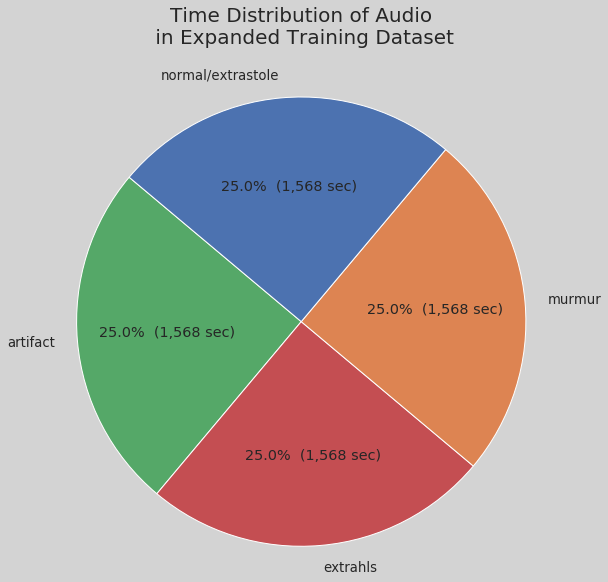

In [25]:
total_duration = df_upsampled.groupby('label')['duration (seconds)'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

#### The results above show the Minority Classes were properly Up-Sampled
+ The training dataset audio has the same distribution for each class
+ There are now 3495 training examples

In [26]:
testing_df['time_series'] = df['fname'].apply(load_audio)   # audio signals
testing_df['duration (seconds)'] = round(testing_df['time_series'].apply(len) / SAMPLE_RATE, 1)

testing_df['mfccs'] = testing_df['time_series'].apply(new_extract_mfccs)
testing_df['zcr'] = testing_df['time_series'].apply(new_extract_zcr)
testing_df['bandwidth'] = testing_df['time_series'].apply(new_extract_bandwidth)

In [27]:
mfccs = np.vstack(df_upsampled['mfccs'])
zcr = np.vstack(df_upsampled['zcr'])
bandwidth = np.vstack(df_upsampled['bandwidth'])

test_mfccs = np.vstack(testing_df['mfccs'])
test_zcr = np.vstack(testing_df['zcr'])
test_bandwidth = np.vstack(testing_df['bandwidth'])

""" Normalize the training data """
mfccs = mfccs / np.std(mfccs, axis=0)
zcr = zcr / np.std(zcr, axis=0)
bandwidth = bandwidth / np.std(bandwidth, axis=0)

""" Normalize the testing data """
test_mfccs = test_mfccs / np.std(test_mfccs, axis=0)
test_zcr = test_zcr / np.std(test_zcr, axis=0)
test_bandwidth = test_bandwidth / np.std(test_bandwidth, axis=0)

## One-Hot Encoding

In [28]:
trainLabels_encoded = pd.get_dummies(df_upsampled['label'])

# Keras Functional API: Deep Neural Networks
<a id="Keras-Functional-API:-Deep-Neural-Networks"></a>

#### Build Multi-Input Model, Set up Model Architecture

In [29]:
""" Define Callback Function """
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

checkpoint = ModelCheckpoint("weights.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, annealer]

In [30]:
warnings.filterwarnings('ignore')

# input tensors: mfccs, zero crossing rate, spectral bandwidth
x1 = Input(shape =(13,), dtype = 'float32', name = 'mfccs')
x2 = Input(shape =(1,), dtype = 'float32', name = 'zcr')
x3 = Input(shape =(1,), dtype = 'float32', name = 'bandwidth')

input_layer = concatenate([x1,x2,x3])

hl1 = Dense(units=64, activation='relu')(input_layer)
hl2 = Dense(units=32, activation='relu')(hl1)
hl3 = Dense(units=16, activation='relu')(hl2)
x = Dropout(rate=0.2)(hl3)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=[x1,x2,x3],
              outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001,
                                decay=1e-6),
                loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfccs (InputLayer)              (None, 13)           0                                            
__________________________________________________________________________________________________
zcr (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
bandwidth (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15)           0           mfccs[0][0]                      
                                                                 zcr[0][0]                        
          

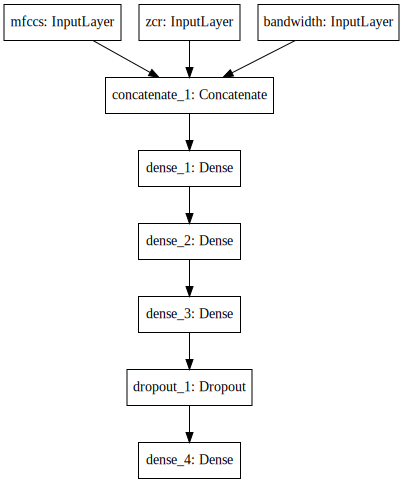

In [31]:
EDA.plot_keras_model(model, show_shapes=False, show_layer_names=True)

## Fit the Model

To avoid overfitting the training data, we only train the model for 10 epochs.

In [32]:
history = model.fit(x = [mfccs, zcr, bandwidth],
                    y = trainLabels_encoded,
                    validation_split=0.1,
                    epochs = 10,
                    batch_size = 8,
                   callbacks=callbacks_list,
                   verbose=1)

Train on 2822 samples, validate on 314 samples
Epoch 1/10
2822/2822 [==============================] - 1s 212us/step - loss: 0.6565 - acc: 0.7257 - val_loss: 0.1282 - val_acc: 0.9459

Epoch 00001: val_loss improved from inf to 0.12818, saving model to weights.hdf5
Epoch 2/10
2822/2822 [==============================] - 0s 101us/step - loss: 0.4649 - acc: 0.7856 - val_loss: 0.0690 - val_acc: 0.9841

Epoch 00002: val_loss improved from 0.12818 to 0.06895, saving model to weights.hdf5
Epoch 3/10
2822/2822 [==============================] - 0s 100us/step - loss: 0.4110 - acc: 0.8122 - val_loss: 0.0271 - val_acc: 0.9904

Epoch 00003: val_loss improved from 0.06895 to 0.02713, saving model to weights.hdf5
Epoch 4/10
2822/2822 [==============================] - 0s 117us/step - loss: 0.3932 - acc: 0.8225 - val_loss: 0.0416 - val_acc: 0.9841

Epoch 00004: val_loss did not improve from 0.02713
Epoch 5/10
2822/2822 [==============================] - 0s 117us/step - loss: 0.3805 - acc: 0.8345 - va

We trained on 2822 samples, and validated on 314 samples. The model performed really well. On the first pass of the data, the model achieved an accuracy of 75% on the training set and an accuracy of 95% on the validation set. Eventually the model achieves an accuracy of 85% on the training set and an accuracy of 99% on the validation set.

<br>

Here we bring back the best weights, in case we overfitted the model.

In [33]:
model.load_weights('weights.hdf5')

# Make Predictions
<a id="Make-Predictions"></a>

In [34]:
testLabels = testing_df['label'].tolist()

y_prob = model.predict([test_mfccs, test_zcr, test_bandwidth])
y_classes = y_prob.argmax(axis=-1)

labelsDict = {'artifact': 0, 'extrahls':1, 'murmur':2, 'normal/extrastole':3}
y_actu = [labelsDict[k] for k in testLabels]
y_pred = y_classes.tolist()

# binarize/hotencode y_actu
y_binary = label_binarize(np.array(y_actu), classes=[0,1,2,3])
n_classes = y_binary.shape[1]    # 4 classes

# Confusion Matrix
<a id="Confusion-Matrix"></a>

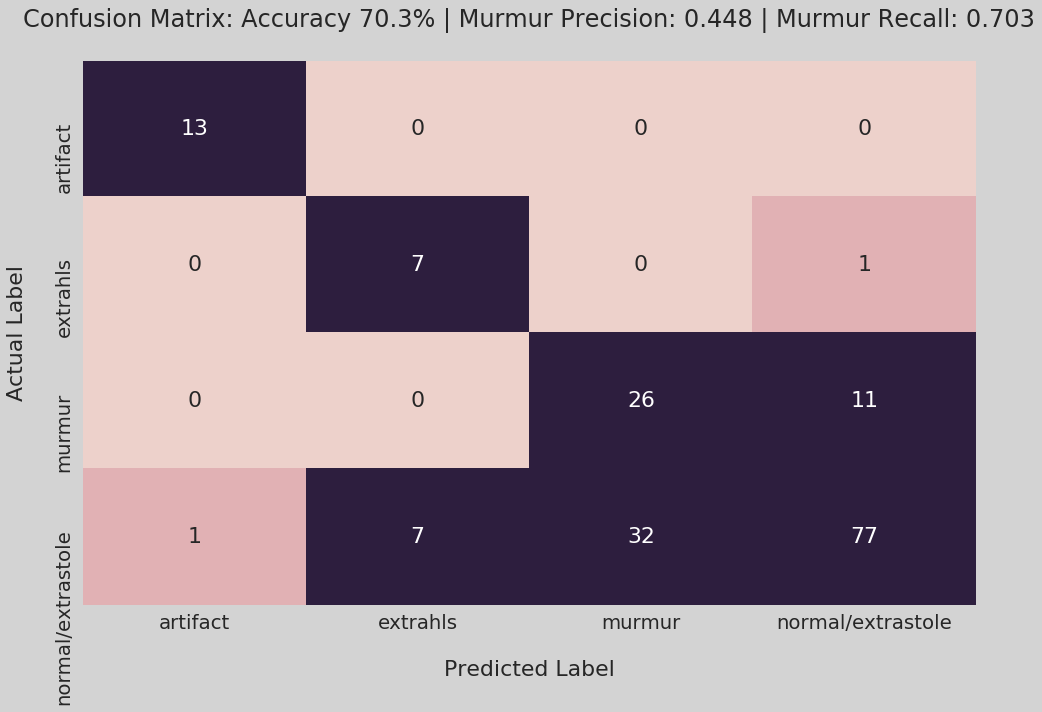

In [35]:
from IPython.display import display, HTML

plt.figure(figsize=(16,10),facecolor='lightgrey')

array = confusion_matrix(y_actu, y_pred).tolist()
categories = ["artifact","extrahls","murmur","normal/extrastole"]
df_cm = pd.DataFrame(array, index = categories, columns = categories)

"""Compute Precision, Recall, F-score """
precision = pd.Series(np.diag(df_cm) / np.sum(df_cm, axis = 0), name='precision')
recall = pd.Series(np.diag(df_cm) / np.sum(df_cm, axis = 1), name='recall')
fscore = pd.Series(2 * precision * recall / (precision + recall), name='F-score')
murmur_precison = round(precision['murmur'],3)
murmur_recall = round(recall['murmur'],3)

sns.set(font_scale=1.8) # label size
sns.heatmap(df_cm, annot=True, square = False, annot_kws={"size": 22}, 
            fmt="d", cmap = sns.cubehelix_palette(8), vmin = 0, vmax = 6, cbar=False)


plt.ylabel('Actual Label\n', size = 22);
plt.xlabel('\nPredicted Label', size = 22); 
cm_title = "Confusion Matrix: Accuracy {0}% | Murmur Precision: {1} | Murmur Recall: {2}\n".format(
    round(accuracy_score(y_actu, y_pred)*100, 1), murmur_precison, murmur_recall)
plt.title(cm_title, size = 24);

The model achieved an overall accuracy of 70.3% on the testing set. This is a pretty good result considering the subtle distinction of audio in the dataset and the fact that the dataset was unbalanced. The class distribution was heavily skewed towards the normal/extrastole category. 

Because the dataset is unbalanced, accuracy is not a reliable measure of model performance. To get a better sense of the model's performance, we have to look at precision, recall, and f-score.features for robust classification

# Precision, Recall, F-score
<a id="Precision,-Recall,-F-score"></a>

Precision is the proportion of correct positive classifications (true positives) from cases that are predicted as positive.

Recall (also called sensitivity) is the proportion of correct positive classifications (true positives) from cases that are actually positive.

F Score is the harmonic mean of Precision and Recall.

In [36]:
pd.concat([precision, recall, fscore], axis=1)

,precision,recall,F-score
artifact,0.928571,1.000000,0.962963
extrahls,0.500000,0.875000,0.636364
murmur,0.448276,0.702703,0.547368
normal/extrastole,0.865169,0.658120,0.747573


The goal of the classifer was to optimize for the murmur category because that category had the highest implication cost. 

Murmur has a precision rate of 0.4483, a recall rate of 0.7027, and an F Score of 0.5474.

# ROC Curve and AUC
<a id="ROC-Curve-and-AUC"></a>

In [37]:
"""Compute ROC curve and ROC area for each class"""
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

"""Compute micro-average ROC curve and ROC area"""
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [38]:
"""Compute macro-average ROC curve and ROC area"""

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

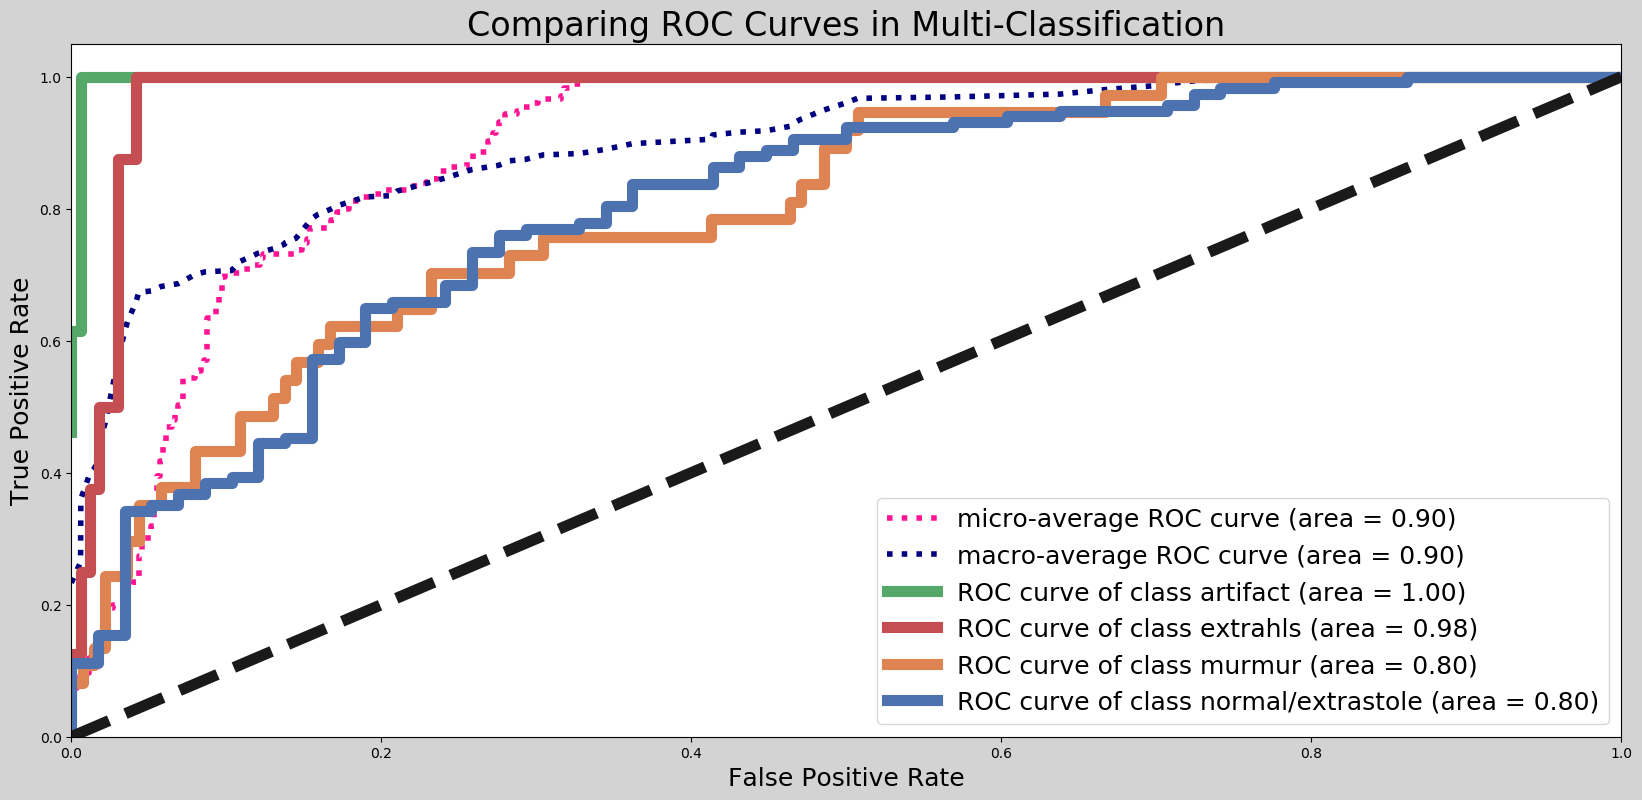

In [39]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(20,9), facecolor='lightgrey')
lw = 8            # line width
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['#55A868', '#C44E52', '#DD8452', '#4C72B0']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Comparing ROC Curves in Multi-Classification', fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.show()

## Interpret ROC Results

An ROC curve demonstrates several things:

<font color='orange'> 1) </font> It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).

<font color='orange'> 2) </font> The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

<font color='orange'> 3) </font> The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

<font color='orange'> 4) </font> The slope of the tangent line at a cutpoint gives the likelihood ratio (LR) for that value of the test. You can check this out on the graph above. Recall that the LR for T4 < 5 is 52. This corresponds to the far left, steep portion of the curve. The LR for T4 > 9 is 0.2. This corresponds to the far right, nearly horizontal portion of the curve.

<font color='orange'> 5) </font> The area under the curve is a measure of text accuracy.

--------------
<br>

The ROC curve for class murmur is well above the 45-degree diagonal. The AUC for the murmur class is 0.77. This indicates that the model is fairly accurate at detecting heart murmurs.

# Conclusion
<a id="Introduction"></a>

In closing, we created a robust and fairly accurate heart sound classifier. I learned a lot in this project.

The model can be improved with a convolutional neural network architecture. Another improvement is to collect more training data so that there isn't class imbalance. 

<br>

This was the 2nd capstone project that I worked on after completing the <a href="https://www.deeplearning.ai/deep-learning-specialization/" target="_blank">Deep Learning Specialization</a> on Coursera. I enjoyed working on this project because it again showcased the types of problems we can solve using machine learning.

Thanks for reading.

$\blacksquare$